# Deploy a Trained TensorFlow V2 Model

In this notebook, we walk through the process of deploying a trained model to a SageMaker endpoint. If you recently ran [the notebook for training](get_started_mnist_deploy.ipynb) with %store% magic, the `model_data` can be restored. Otherwise, we retrieve the 
model artifact from a public S3 bucket.

In [2]:
# setups

import os
import json

import sagemaker
from sagemaker.tensorflow import TensorFlowModel
from sagemaker import get_execution_role, Session
import boto3

# Get global config
with open("code/config.json", "r") as f:
    CONFIG = json.load(f)

sess = Session()
role = get_execution_role()

%store -r tf_mnist_model_data


try:
    tf_mnist_model_data
except NameError:
    import json

    # copy a pretrained model from a public bucket to your default bucket
    s3 = boto3.client("s3")
    bucket = CONFIG["public_bucket"]
    key = "datasets/image/MNIST/model/tensorflow-training-2020-11-20-23-57-13-077/model.tar.gz"
    s3.download_file(bucket, key, "model.tar.gz")
    tf_mnist_model_data = sess.upload_data(
        path="model.tar.gz", bucket=sess.default_bucket(), key_prefix="model/tensorflow"
    )
    os.remove("model.tar.gz")

In [3]:
print(tf_mnist_model_data)

s3://sagemaker-ap-southeast-2-431579215499/tensorflow/mnist/tensorflow-training-2022-06-06-03-53-29-103/output/model.tar.gz


## TensorFlow Model Object

The `TensorFlowModel` class allows you to define an environment for making inference using your
model artifact. Like `TensorFlow` estimator class we discussed 
[in this notebook for training an Tensorflow model](
get_started_mnist_train.ipynb), it is high level API used to set up a docker image for your model hosting service.

Once it is properly configured, it can be used to create a SageMaker
endpoint on an EC2 instance. The SageMaker endpoint is a containerized environment that uses your trained model 
to make inference on incoming data via RESTful API calls. 

Some common parameters used to initiate the `TensorFlowModel` class are:
- role: An IAM role to make AWS service requests
- model_data: the S3 bucket URI of the compressed model artifact. It can be a path to a local file if the endpoint 
is to be deployed on the SageMaker instance you are using to run this notebook (local mode)
- framework_version: version of the MXNet package to be used
- py_version: python version to be used

In [4]:
model = TensorFlowModel(
    role=role,
    model_data=tf_mnist_model_data,
    framework_version="2.3.1",
)

## Execute the Inference Container
Once the `TensorFlowModel` class is initiated, we can call its `deploy` method to run the container for the hosting
service. Some common parameters needed to call `deploy` methods are:

- initial_instance_count: the number of SageMaker instances to be used to run the hosting service.
- instance_type: the type of SageMaker instance to run the hosting service. Set it to `local` if you want run the hosting service on the local SageMaker instance. Local mode are typically used for debugging. 

<span style="color:red"> Note: local mode is not supported in SageMaker Studio </span>

In [5]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# set local_mode to False if you want to deploy on a remote
# SageMaker instance

local_mode = False

if local_mode:
    instance_type = "local"
else:
    instance_type = "ml.c4.xlarge"

predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


----!

## Making Predictions Against a SageMaker endpoint

Once you have the `Predictor` instance returned by `model.deploy(...)`, you can send prediction requests to your endpoints. In this case, the model accepts normalized 
batch images in depth-minor convention. 

In [6]:
# use some dummy inputs
import numpy as np

dummy_inputs = {"instances": np.random.rand(4, 28, 28, 1)}

res = predictor.predict(dummy_inputs)
print(res)

{'predictions': [[-3.07496858, -1.92263961, 0.40784055, 2.68889284, -4.51269293, 1.26628399, -0.371436179, -1.60043943, -1.73814678, -1.44925392], [-2.78310299, -2.50181174, 0.196516275, 2.38543034, -4.89259768, 1.30999255, -0.287920415, -1.23828626, -1.47772789, -2.17345548], [-2.62833285, -2.2909236, 0.589692771, 2.63945913, -4.41077375, 0.810409307, -0.695943296, -1.64216757, -1.58362, -1.63197041], [-2.6050365, -2.26944327, 0.382466316, 2.50133753, -4.92548084, 1.26441634, 0.0326526649, -1.47540545, -1.75987828, -1.9871254]]}


The formats of the input and output data correspond directly to the request and response
format of the `Predict` method in [TensorFlow Serving REST API](https://www.tensorflow.org/tfx/serving/api_rest), for example, the key of the array to be 
parsed to the model in the `dummy_inputs` needs to be called `instances`. Moreover, the input data needs to have a batch dimension. 

In [7]:
# Uncomment the following lines to see an example that cannot be processed by the endpoint

# dummy_data = {
#    'instances': np.random.rand(28, 28, 1).tolist()
# }
# print(predictor.predict(inputs))

Now, let's use real MNIST test to test the endpoint. We use helper functions defined in `code.utils` to 
download MNIST data set and normalize the input data.

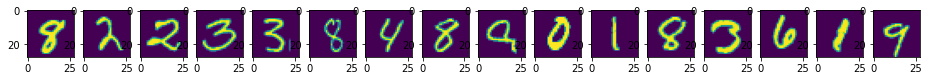

In [8]:
from utils.mnist import mnist_to_numpy, normalize
import random
import matplotlib.pyplot as plt

%matplotlib inline

data_dir = "/tmp/data"
X, _ = mnist_to_numpy(data_dir, train=False)

# randomly sample 16 images to inspect
mask = random.sample(range(X.shape[0]), 16)
samples = X[mask]

# plot the images
fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(16, 1))

for i, splt in enumerate(axs):
    splt.imshow(samples[i])

Since the model accepts normalized input, you will need to normalize the samples before 
sending it to the endpoint. 

In [9]:
samples = normalize(samples, axis=(1, 2))
predictions = predictor.predict(np.expand_dims(samples, 3))["predictions"]  # add channel dim

# softmax to logit
predictions = np.array(predictions, dtype=np.float32)
predictions = np.argmax(predictions, axis=1)

In [10]:
print("Predictions: ", predictions.tolist())

Predictions:  [8, 2, 2, 3, 3, 8, 4, 8, 9, 0, 1, 8, 3, 6, 1, 9]


## (Optional) Clean up 

If you do not plan to use the endpoint, you should delete it to free up some computation 
resource. If you use local, you will need to manually delete the docker container bounded
at port 8080 (the port that listens to the incoming request).


In [11]:
import os

if not local_mode:
    predictor.delete_endpoint()
else:
    os.system("docker container ls | grep 8080 | awk '{print $1}' | xargs docker container rm -f")